In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as sLA

from IPython.display import Image
from IPython.display import display, Latex

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

from matplotlib import style
# style.use('ggplot')

In [2]:
from scipy import linalg as sLA
from scipy.special import hermite, factorial
from scipy.integrate import quad
from scipy.stats import chi2, chisquare
from scipy import interpolate
from tqdm import tqdm

In [3]:
#Вычисление Фиделити для векторов чистых состояний
def Fidelity_pure(vec0, vec1):
    return np.abs(np.dot(vec0, vec1.conjugate())) ** 2

# Функция для отрисовки 3-D barchart
def plot_matrix(m, title = 'Входное состояние'):
    
    style.use('ggplot')

    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(111, projection='3d')
    
    xi = np.reshape(list(np.arange(m.shape[0]))*m.shape[1], (-1))
    yi = np.reshape(np.reshape((list(np.arange(m.shape[1]))*m.shape[0]), (m.shape[1], m.shape[0])).T, (-1))
    z0 = np.zeros(m.shape[0]*m.shape[1])
    
    dx = np.ones(m.shape[0]*m.shape[1])
    dy = np.ones(m.shape[1]*m.shape[0])
    dz = np.reshape(m, (-1))
    
    ax1.bar3d(xi, yi, z0, dx, dy, dz, shade=True)


    ax1.set_xlabel('Колличество фотонов во втором канале n2')
    ax1.set_ylabel('Колличество фотонов в первом канале n1')
    ax1.set_zlabel('Вероятность p1p2')
    ax1.set_title(title)

    plt.show()

# Пункт 1:
### Зададим состояниее согласно 3-му варианту и определим для него фоковское пространство, достаточное для представленияя с точностью $10^{-6}$

Вариант 3:

Рассматриваемое состояние:

$\phi ~ | \alpha \rangle + |1 \rangle$, где $\alpha = 0.9i$ =>

$\phi =  (|1 \rangle + e^{\frac{-|\alpha|^2}{2}} \sum_{n=0}^{n_{max}} \frac{\alpha^{n}}{\sqrt{n!}} |n\rangle) /  norm$, где $n = 0.9i$

In [4]:
# Создаёт когерентное состояние
def get_rho_coherent(N, d, alpha = 0.9*1j):
    n = np.arange(N)
    fact_n = np.array([np.math.factorial(x) for x in n]).astype(float)
    state = np.exp((-np.abs(alpha) ** 2) / 2) * (alpha ** n) / np.sqrt(fact_n)
    rho = np.outer(state,state.conjugate())
    
    rho_full = np.zeros((d,d))
    rho_full[:N,:N] = rho
    return rho_full, state


def get_coherent_probs(n, alpha = 0.9*1j):
    return np.exp((-np.abs(alpha) ** 2)) * (np.abs(alpha) ** (2*n)) / float(np.math.factorial(n))

def get_coherent_coefs(n, alpha = 0.9*1j):
    return np.exp((-np.abs(alpha) ** 2) / 2) * (alpha ** (2*n)) / np.sqrt(float(np.math.factorial(n)))
    
# Расчитывает ошибку ограничения размерности рассматриваемой системы
def restrictions_err(N, func = get_coherent_probs):
    return 1 - sum([func(i) for i in range(N)])

def get_my_state(N, d):
    _, state = get_rho_coherent(N, d, alpha = 0.9*1j)
    state1 = np.zeros(len(state))
    state1[1] = 1
    state += state1
    norm_coef = np.sqrt(state@state.conj())
    
    state = state/norm_coef
    rho = np.outer(state,state.conjugate())
    
    rho_full = np.zeros((d,d))
    rho_full[:N,:N] = rho
    return rho, state

Заданное состояние является суперпозицией фоковского и когерентного. При этом фоковское cостояние $|1 \rangle$ представляется точно в рассматриваемом фоковском пространнстве $n>=1$.
Будем следить только за точностью представления когерентного состояния.

Найдём размерность достаточную для представления когерентного состояния с точностью $10^{-6}$

In [5]:
print('Ошибка в распределении за счёт сокращения размерности до 8:', restrictions_err(8))
print('Ошибка в распределении за счёт сокращения размерности до 9:', restrictions_err(9))

Ошибка в распределении за счёт сокращения размерности до 8: 2.244554789920805e-06
Ошибка в распределении за счёт сокращения размерности до 9: 2.0008311862884653e-07


Достаточно рассмотреть фоковское пространство размерностью 9

In [6]:
N = 9
# Получим заданное состояние
my_rho, my_state = get_my_state(N, N)

# Определим массив коэфициентов cn при соответствующих состояниях |n>
cn_list = my_state

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part



# Пункт 2:
#### Зададим состояние через разложение на полиномы Эрмита

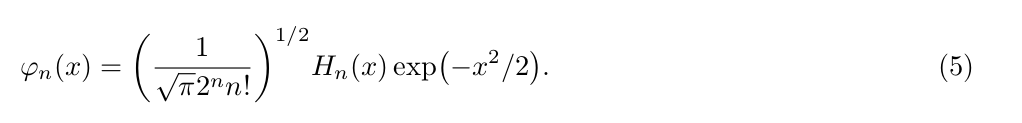

In [7]:
from IPython.display import Image
Image(filename='pics/Chebyshev_hermit_basis.png')

Также учтём зависимость от фазы

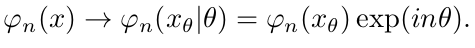

In [8]:
Image(filename='pics/psi_theta.png')

И окончательно получим состояние через найденные пункте 1 коэффициенты $c_n$

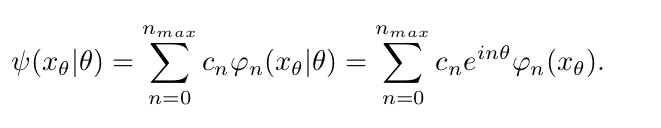

In [9]:
Image(filename='pics/state.png')

In [10]:
def phi_theta(n, x, theta):
    return (1/(np.pi**0.5*2**n*factorial(n)))**(1/2)*hermite(n)(x)*np.exp(-x**2/2)*np.exp(1j*n*theta)

def get_theor_state(cn_list, N, x, theta):
    return np.sum(np.array([cn_list[i]*phi_theta(i, x, theta) for i in range(N)]), axis = 0)
    
def get_probs(state):
    return abs(state)**2

# Более быстрая функция для вероятности. Понадобится при решении УП
def p_(phi_theta, psi):
    return abs(np.tensordot(psi, phi_theta, axes=1))**2

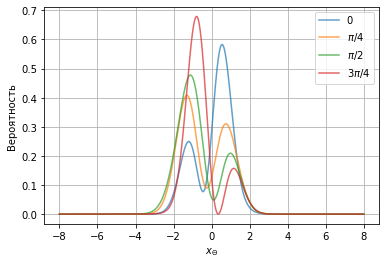

In [11]:
x_list = np.linspace(-8, 8, 1000)
thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
thetas_label = ['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$']

for theta, theta_label in zip(thetas, thetas_label):
    p_list = get_probs(get_theor_state(cn_list, N, x_list, theta))
    plt.plot(x_list, p_list, '-', alpha=0.7, label=theta_label)
plt.xlabel('$x_\Theta$')
plt.ylabel('Вероятность')
plt.legend()
plt.grid()
plt.show()

# Пункт 3:
#### Выполним симуляцию измерений для каждого значения $\theta$

In [12]:
def F(z, x_list, state):
    return np.trapz(get_probs(state)[x_list <= z], x_list[x_list <= z])

In [13]:
n = 10000
L = 10
inv_points = 1000



x_list = np.linspace(-L, L, inv_points)

thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
thetas_label = ['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$']

Func_list = []
x_rec_list = []

for theta in thetas:
    y = []
    state = get_theor_state(cn_list, N, x_list, theta)
    for x_inv in tqdm(x_list):
        y.append(F(x_inv, x_list, state))
                 
    # Восстановим функцию распределения
    F_inv = interpolate.interp1d(y, x_list, fill_value=(0, 1), bounds_error=False)
    Func_list.append(F_inv)
    
    # Из восстановленной ф-ии распределения сгенерируем 1000 случайных величин
    # Каждое соответствует измерению
    y_random = np.random.rand(n)
    x_reconstructed = F_inv(y_random)
    x_rec_list.append(x_reconstructed)
    

100%|██████████| 1000/1000 [00:00<00:00, 19593.60it/s]


#### Построим соответствующие распределения

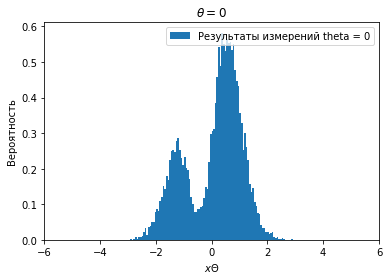

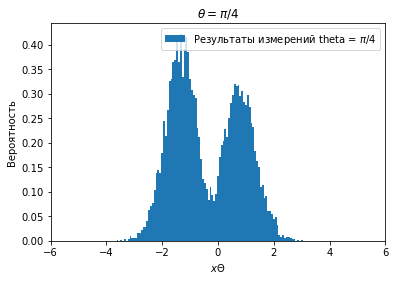

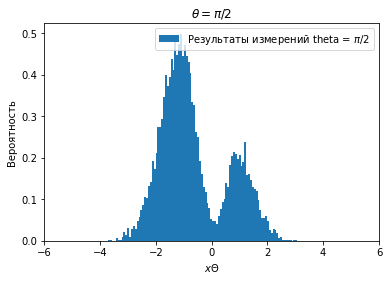

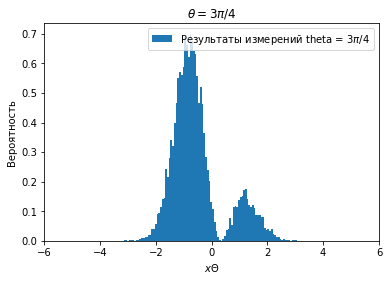

In [14]:
for x_rec, theta_label in zip(x_rec_list, thetas_label):   
    plt.hist(x_rec, bins=100, density=True, label=f'Результаты измерений theta = {theta_label}')
    plt.xlabel('$x \Theta$')
    plt.ylabel('Вероятность')
    plt.title(r'$\theta = $' + f'{theta_label}')
    plt.xlim(-6, 6)
    plt.legend()
    plt.show()

# Пункт 4:

#### Проведём реконструкцию состояния методом MLE

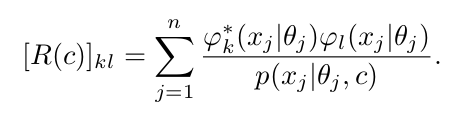

In [15]:
Image(filename='pics/R_matrix.png')

Создадим полный набор $(x_j, \theta_j)$

In [16]:
len(x_rec_list[0])

10000

In [17]:
# Полный набор измерений состоит из 4000 измерений по 4000 на каждую theta
x_rec_list = np.array(x_rec_list)

thetas_list = []
for theta in thetas:
    thetas_list.append([theta]*x_rec_list.shape[1])
    
thetas_list = np.array(thetas_list)


In [18]:
# Зададим функцию собирающую матрицу R(c)

# Заметим, что числители дробей в сумме выше не зависят от c. 
# Посчитаем их заранее, чтобы не пересчитывать на каждой итерации далее


def get_R_numerators(N = 9, thetas = thetas, x_rec_list = x_rec_list):
    psi_n_list = []
    for n in range(N):
        psi = []
        for theta, x in zip(thetas, x_rec_list):       
            psi.append(phi_theta(n, x, theta))
        psi = np.array(psi).flatten()
        psi_n_list.append(psi)
    
    numerators_list = np.reshape([psi1.conj()*psi2 for psi1 in psi_n_list for psi2 in  psi_n_list], (9,9,40000))                       
    return np.array(numerators_list).T

numerators_list = get_R_numerators()

In [19]:
def get_R(c, numerators_list):
    denumerators_list = []
    for theta, x in zip(thetas, x_rec_list):
        state = get_theor_state(c, N, x, theta)
        p = get_probs(state)
        denumerators_list.append(p)
        
    denumerators_list = np.array(denumerators_list).flatten()
    return np.sum(numerators_list/np.reshape(denumerators_list, (40000, 1, 1)), axis = 0).T
    
    

In [20]:
# Проверим работу ф-ии
c = np.random.randn(9)
c = c/np.sqrt(c**2)
R = get_R(c, numerators_list)
print(R)

[[ 37184052.42846053+0.00000000e+00j -15098606.12325043-1.24107695e+04j
    3228356.58005526-8.08907595e+03j   4674247.03436078+1.71066653e+03j
  -16840236.23581999-4.67925575e-12j   4952565.3616227 -1.46620376e+03j
   20867084.12605689+2.06586101e+03j -11865725.6657968 +3.78087969e+03j
  -20037498.86190833-2.61633130e-12j]
 [-15098606.12325043+1.24107695e+04j  41793003.22624996+0.00000000e+00j
  -13268731.65777189-1.51495978e+04j -28114087.33340783-5.80174811e+02j
   20422766.88032075+6.69986434e+03j  13449459.17669742-2.33561101e-11j
  -19306705.28907944+1.32614982e+03j  -1478854.13583685+1.01182790e+04j
   14285064.34094748+3.92854880e+03j]
 [  3228356.58005526+8.08907595e+03j -13268731.65777189+1.51495978e+04j
    5059634.4684757 +0.00000000e+00j   9264990.6581425 -5.19580813e+03j
   -6608604.2260584 +1.01720811e+04j  -4650957.30668489+7.25969417e+03j
    5738134.25608464+9.15011077e-14j    811114.26493062+7.38026411e+03j
   -3771749.17445724+7.03882060e+03j]
 [  4674247.03436078-1

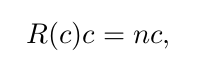

In [21]:
Image(filename='pics/iter_method.png')

In [22]:
%%time

eps = 1e-8
mu=0.5

# Зададим случайное чистое состояние в качестве начального приближения
c = np.random.randn(9)
c = c/np.sqrt(c**2)

for i in tqdm(range(1000)):
    c_prev = c
    c = (1-mu)*get_R(c_prev, numerators_list) @ c_prev/ 40000 + mu*c_prev
    print(np.sum(abs(c_prev - c)**2)**0.5)
    if np.sum(abs(c_prev - c)**2)**0.5 < eps:
        break
    
    


  0%|          | 3/1000 [00:00<01:33, 10.71it/s]

1.3528479312304584
0.5888095174032075
0.22037521250834977


  0%|          | 5/1000 [00:00<01:35, 10.43it/s]

0.14942605391670694
0.1182712768628737
0.411371162176309


  1%|          | 9/1000 [00:00<01:29, 11.03it/s]

0.22254255893439076
0.18264862383192662
0.1351584265433232


  1%|          | 11/1000 [00:01<01:30, 10.99it/s]

0.10030310863329005
0.07084608713200778
0.05242387305975148


  2%|▏         | 15/1000 [00:01<01:30, 10.85it/s]

0.03753070789372557
0.029399038813634985
0.020277748950289866


  2%|▏         | 17/1000 [00:01<01:30, 10.89it/s]

0.015552730880936009
0.012132231071664586


  2%|▏         | 19/1000 [00:01<01:33, 10.52it/s]

0.009517309593672491
0.00745799574943435
0.005829221733980143


  2%|▏         | 23/1000 [00:02<01:30, 10.84it/s]

0.0045502184515325075
0.003555749394175996
0.0027882755445714533


  2%|▎         | 25/1000 [00:02<01:30, 10.76it/s]

0.0021975196373384565
0.001741711368795493
0.0013879470191910952


  3%|▎         | 27/1000 [00:02<01:32, 10.47it/s]

0.0011113084429347183
0.0008933248235718665


  3%|▎         | 31/1000 [00:02<01:34, 10.30it/s]

0.0007203798345247842
0.0005823793402098878
0.0004717529743292547


  3%|▎         | 33/1000 [00:03<01:32, 10.41it/s]

0.0003827457891853358
0.000310925870959921
0.0002528416741820102


  4%|▎         | 37/1000 [00:03<01:32, 10.45it/s]

0.00020578029424609583
0.00016759364957099428
0.00013657095091857663


  4%|▍         | 39/1000 [00:03<01:30, 10.58it/s]

0.00011134337618436183
9.081167258745484e-05
7.40904444957424e-05


  4%|▍         | 43/1000 [00:04<01:28, 10.78it/s]

6.0464823353109266e-05
4.9356478567446623e-05
4.029677127268721e-05


  4%|▍         | 45/1000 [00:04<01:27, 10.88it/s]

3.290543080551193e-05
2.687353986346389e-05
2.1949906103470588e-05


  5%|▍         | 49/1000 [00:04<01:25, 11.16it/s]

1.7930111629839157e-05
1.4647690861396406e-05
1.19670072563786e-05


  5%|▌         | 51/1000 [00:04<01:28, 10.78it/s]

9.777490937702207e-06
7.988969815609624e-06
6.527881619030656e-06


  6%|▌         | 55/1000 [00:05<01:26, 10.93it/s]

5.334197136484211e-06
4.358918730635125e-06
3.5620449112640925e-06


  6%|▌         | 57/1000 [00:05<01:25, 11.01it/s]

2.910912994978642e-06
2.3788488362272345e-06
1.944066195322656e-06


  6%|▌         | 59/1000 [00:05<01:28, 10.59it/s]

1.5887692179998135e-06
1.29842028806719e-06


  6%|▋         | 63/1000 [00:05<01:31, 10.24it/s]

1.0611426052467737e-06
8.672325752180362e-07
7.087617435825162e-07


  6%|▋         | 65/1000 [00:06<01:28, 10.58it/s]

5.792517719342137e-07
4.7340901374944694e-07
3.8690773364478567e-07


  7%|▋         | 69/1000 [00:06<01:24, 11.01it/s]

3.162130365222954e-07
2.584362192869995e-07
2.1121659959269008e-07


  7%|▋         | 71/1000 [00:06<01:23, 11.09it/s]

1.7262496870671788e-07
1.4108470748775235e-07
1.1530733083632185e-07


  7%|▋         | 73/1000 [00:06<01:24, 11.04it/s]

9.423981964781006e-08
7.702158313025106e-08


  8%|▊         | 75/1000 [00:07<01:29, 10.29it/s]

6.294928953346306e-08
5.144812626783064e-08


  8%|▊         | 78/1000 [00:07<01:44,  8.81it/s]

4.204831326365363e-08
3.436590932935663e-08


  8%|▊         | 81/1000 [00:07<01:38,  9.34it/s]

2.808712638039474e-08
2.2955510401661832e-08
1.8761465064227902e-08


  8%|▊         | 83/1000 [00:07<01:31,  9.97it/s]

1.533368977200828e-08
1.2532182334856818e-08
1.0242520228875047e-08


  8%|▊         | 84/1000 [00:08<01:28, 10.35it/s]

8.371186833150245e-09
CPU times: user 7.49 s, sys: 677 ms, total: 8.16 s
Wall time: 8.12 s


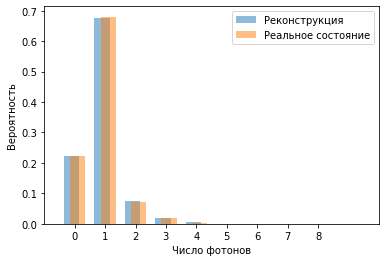

In [23]:
n_list = np.arange(9)

plt.bar(n_list-0.1, abs(c)**2, alpha=0.5, width=0.5, label='Реконструкция')
plt.bar(n_list+0.1, abs(cn_list)**2, alpha=0.5, width=0.5, label='Реальное состояние')
plt.xticks(n_list)
plt.xlim(-1, 10)
plt.xlabel('Число фотонов')
plt.ylabel('Вероятность')
plt.legend()
plt.show()

In [24]:
# Рассчитаем Fidelity между реконструкцией и реальным состоянием
Fidelity_pure(c, cn_list)

0.999811079157391

Состояния совпадаяют с высокой точностью

# Пункт 4:

#### Построим распределения для различных $\theta$

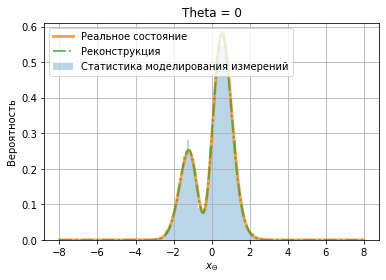

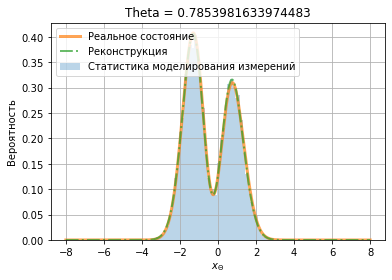

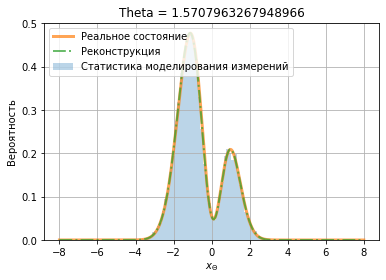

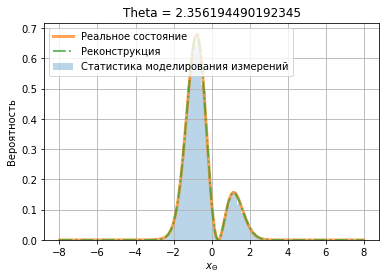

In [25]:
x_list = np.linspace(-8, 8, 1000)
thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
thetas_label = ['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$']


for x, theta, theta_label in zip(x_rec_list, thetas, thetas_label):
    
    plt.hist(x, density = True, bins = 50, alpha = 0.3, label = 'Статистика моделирования измерений')
    
    p_list = get_probs(get_theor_state(cn_list, N, x_list, theta))
    plt.plot(x_list, p_list, '-', linewidth = 3, alpha=0.7, label='Реальное состояние')
    
    p_list = get_probs(get_theor_state(c, N, x_list, theta))
    plt.plot(x_list, p_list, '-.', linewidth = 2, alpha=0.7, label='Реконструкция')
    
    plt.title(f'Theta = {theta}')
    plt.xlabel(
        '$x_\Theta$')
    plt.ylabel('Вероятность')
    plt.legend(loc='upper left')
    plt.grid()
    
    plt.show()
    
    

# Пункт 6:

#### Вычислим p-value для всех $\theta$

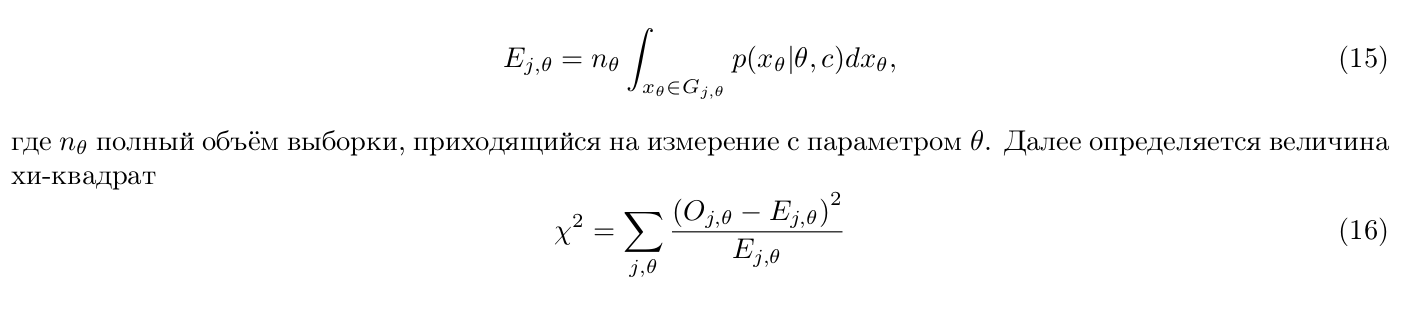

In [26]:
Image(filename='pics/Chi2.png')

In [27]:
# Разобьём данные по квантилям, чтобы в один бин не попадало менее 5-ти измерений
n_bins = 10
nt = 10000



E_list = []
O_list = []

for x, theta in zip(x_rec_list, thetas):
    x = np.array(sorted(x))
#     x_bins = np.quantile(x, np.linspace(0,1,n_bins+1))
    x_bins = np.linspace(x.min(), x.max(), n_bins+1)
    x_bin_prev = x_bins[0]
    for x_bin in x_bins[1:]:
        x_vals = x[(x<x_bin) & (x>=x_bin_prev)]
        O = len(x_vals)
        
        # Слипание бинов, где выборка меньше заданного уровня
        # Взял 20, тк выборка не 1000 а 10 000
        if O < 20:
            continue
            
        E = nt * np.trapz(get_probs(get_theor_state(c, N, x_vals, theta)), x_vals)
        E_list.append(E)
        O_list.append(O)
        
        x_bin_prev = x_bin
        
O_list = np.array(O_list)
E_list = np.array(E_list)

Xi2 = np.sum((O_list - E_list)**2/E_list)

In [28]:
print(O_list)

[  57  387 1273 1048  796 2756 2623  917  129   22  247 1391 2525 1293
 1016 1963 1233  284   25   41  341 1452 2959 2220  504 1136 1048  278
   20  204 1421 3776 2714  255  701  702  212]


In [30]:
nu = 4*n_bins - len(thetas) - 2*(N - 1) + 1
p_value = 1 - chi2.cdf(np.abs(Xi2), nu)
print('p-value = ' + str(p_value))

p-value = 0.2619504812987692


In [31]:
Xi2, nu

(24.665312141810052, 21)

Для визуализации разобьём на меньшее количество бинов (n_bins = 10)

In [32]:
# Разобьём данные по квантилям, чтобы в один бин не попадало менее 5-ти измерений
n_bins = 10
nt = 10000

E_list = []
O_list = []

for x, theta in zip(x_rec_list, thetas):
    x = np.array(sorted(x))
#     x_bins = np.quantile(x, np.linspace(0,1,n_bins+1))
    x_bins = np.linspace(x.min(), x.max(), n_bins+1)
    x_bin_prev = x.min()
    
    for x_bin in x_bins[1:]:
        x_vals = x[(x<x_bin) & (x>x_bin_prev)]
        O = len(x_vals)
        
        if O < 20:
            continue
            
        E = nt * np.trapz(get_probs(get_theor_state(c, N, x_vals, theta)), x_vals)
        E_list.append(E)
        O_list.append(O)
        
        x_bin_prev = x_bin
        
O_list = np.array(O_list)
E_list = np.array(E_list)

Xi2 = np.sum((O_list - E_list)**2/E_list)

In [33]:
print(f'Статистика Сhi2: {Xi2}')
print(f'Число степеней свободы: {nu}')

Статистика Сhi2: 24.516179359234737
Число степеней свободы: 21


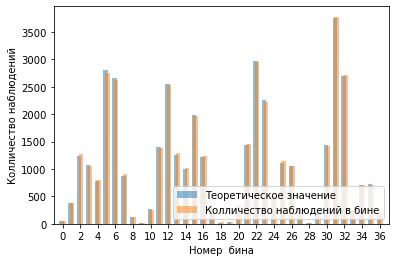

In [34]:
n_list = np.arange(E_list.shape[0])

plt.bar(n_list-0.1, E_list, alpha=0.5, width=0.5, label='Теоретическое значение')
plt.bar(n_list+0.1, O_list, alpha=0.5, width=0.5, label='Колличество наблюдений в бине')
plt.xticks(n_list[0::2])
plt.xlim(-1, E_list.shape[0])
plt.xlabel('Номер  бина')
plt.ylabel('Колличество наблюдений')
plt.legend(loc = 'lower right')
plt.show()